In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from PIL import Image
import os

### Parameters

In [8]:
in_channels = 3
n_epochs=35
max_lr = 0.001
weight_decay = 1e-4
image_size=64
batch_size = 84

train_dir = 'data/cats/train'
valid_dir = 'data/cats/valid'
test_image_path = 'data/cats/input/image1.jpg'

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Transformation for the training and valid
added a horizontal flip for the training data

In [10]:
# Data transformations
transform = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.Resize((image_size, image_size)),
    tt.ToTensor(),
    # tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transformv = tt.Compose([
    tt.Resize((image_size, image_size)),
    tt.ToTensor(),
    # tt.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_ds = ImageFolder(train_dir, transform=transform)
valid_ds = ImageFolder(valid_dir, transform=transformv)

# Data loaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size, shuffle=False)

##### Plot a batch of images

Labels: ['Angry', 'Disgusted', 'Happy', 'Normal', 'Sad', 'Scared', 'Surprised']


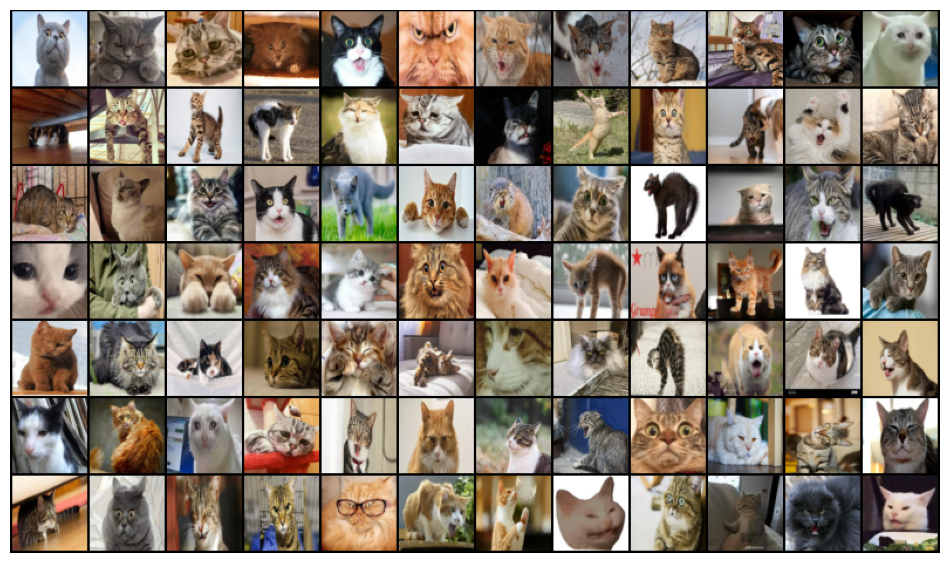

In [21]:

def show_batch(dl):
    for images, labels in dl:
        plt.figure(figsize=(12, 12))
        plt.axis('off')
        plt.imshow(make_grid(images, nrow=12).permute(1, 2, 0))
        plt.show()
        break

print("Labels:", train_ds.classes)
show_batch(train_loader)

##### CNN block

In [ ]:
def ConvolutionBlock(in_channels, out_channels, pool=False):
    layers = [
    nn.Conv2d(in_channels,out_channels,kernel_size=3, stride=1, padding=1),
    nn.BatchNorm2d(out_channels),
    nn.ReLU(inplace=True),
    ]
    if pool: layers.append(nn.MaxPool2d(2)) #change
    return nn.Sequential(*layers)


class CatEmotionCNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CatEmotionCNN, self).__init__()

        self.input = ConvolutionBlock(in_channels, 64)

        self.conv1 = ConvolutionBlock(64, 64, pool=True)
        self.res1 = nn.Sequential(ConvolutionBlock(64, 32), ConvolutionBlock(32, 64))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv2 = ConvolutionBlock(64, 64, pool=True)
        self.res2 = nn.Sequential(ConvolutionBlock(64, 32), ConvolutionBlock(32, 64))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv3 = ConvolutionBlock(64, 64, pool=True)
        self.res3 = nn.Sequential(ConvolutionBlock(64, 32), ConvolutionBlock(32, 64))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(64,num_classes ))
        
    
    def forward(self, x):
        out = self.input(x)

        out = self.conv1(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv2(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv3(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        return self.classifier(out)

##### Optimizer and model loading

In [ ]:
model = CatEmotionCNN(in_channels, num_classes=len(train_ds.classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr, weight_decay=weight_decay)

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []


#### training

In [22]:
def train_model(model, train_loader, valid_loader, epochs=n_epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = correct_train / total_train
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        valid_loss = 0
        correct_valid = 0
        total_valid = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                valid_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_valid += (preds == labels).sum().item()
                total_valid += labels.size(0)

        valid_acc = correct_valid / total_valid
        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(valid_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, Valid Acc: {valid_acc:.4f}")

#### Training loss, accuracy and confusion matrix plots

In [ ]:
def plot_metrics():
    epochs_range = range(len(train_losses))
    
    plt.figure(figsize=(12, 6))
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
    plt.plot(epochs_range, valid_accuracies, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.show()


# Confusion matrix
def plot_confusion_matrix(model, valid_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(valid_ds.classes)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=valid_ds.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

#### misc: 
save model, random prediction from valid folder and input image

In [23]:

def save_model(model, path):
    torch.save(model.state_dict(), path)

def show_random_prediction(model, valid_ds):
    model.eval()
    idx = random.randint(0, len(valid_ds) - 1)
    image, true_label = valid_ds[idx]
    image = image.unsqueeze(0).to(device)
    true_label_name = valid_ds.classes[true_label]

    with torch.no_grad():
        pred = model(image)
        predicted_label = torch.argmax(pred, dim=1).item()
        predicted_label_name = valid_ds.classes[predicted_label]

    plt.imshow(image.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5)
    plt.title(f"True: {true_label_name}, Predicted: {predicted_label_name}")
    plt.axis('off')
    plt.show()

def test_single_image(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transformv(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(image)
        predicted_label = torch.argmax(pred, dim=1).item()
        predicted_label_name = train_ds.classes[predicted_label]

    plt.imshow(image.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5)
    plt.title(f"Predicted: {predicted_label_name}")
    plt.axis('off')
    plt.show()

In [ ]:

train_model(model, train_loader, valid_loader) 

Epoch 1/35, Train Loss: 1.3839, Valid Loss: 1.9019, Train Acc: 0.4741, Valid Acc: 0.1302
Epoch 2/35, Train Loss: 1.3195, Valid Loss: 1.9445, Train Acc: 0.5339, Valid Acc: 0.1775
Epoch 3/35, Train Loss: 1.2789, Valid Loss: 1.9267, Train Acc: 0.5040, Valid Acc: 0.2189
Epoch 4/35, Train Loss: 1.2657, Valid Loss: 1.9175, Train Acc: 0.5259, Valid Acc: 0.2544
Epoch 5/35, Train Loss: 1.2781, Valid Loss: 1.9614, Train Acc: 0.5359, Valid Acc: 0.2130
Epoch 6/35, Train Loss: 1.2798, Valid Loss: 1.8807, Train Acc: 0.5239, Valid Acc: 0.2308
Epoch 7/35, Train Loss: 1.2024, Valid Loss: 1.9596, Train Acc: 0.5578, Valid Acc: 0.1893
Epoch 8/35, Train Loss: 1.1846, Valid Loss: 1.9000, Train Acc: 0.5717, Valid Acc: 0.2130
Epoch 9/35, Train Loss: 1.1846, Valid Loss: 1.8672, Train Acc: 0.5857, Valid Acc: 0.2426
Epoch 10/35, Train Loss: 1.1916, Valid Loss: 1.7375, Train Acc: 0.5558, Valid Acc: 0.2130


In [ ]:
plot_metrics()
plot_confusion_matrix(model, valid_loader)
test_single_image(model, test_image_path)
show_random_prediction(model, valid_ds)